In [1]:
%matplotlib inline
import geopandas as gpd
import pandas as pd
from pathlib import Path
from nldi_xstool.ancillary import queryDEMsShape, getGageDatum
from nldi_xstool.nldi_xstool import getXSAtPoint, getXSAtEndPts
from shapely.geometry import LineString, Point
import py3dep
from pynhd import NLDI, NHDPlusHR, WaterData
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import dataretrieval.nwis as nwis
import requests
# import plotly.express as px
import folium
from folium import plugins
import time

from helpers import plotGageLocation, plotGageXS, interpTValues, plotGageXS_meas

In [2]:
file = Path('../data/01451800_6-28-21.csv')
print(file.exists())
data = pd.read_csv(file)
data

True


,index,lat_SPC,lon_SPC,measured_elevation,notes1,notes2
0,100,491028.924,2557417.389,8.476,xs_left,start of XS on left bank
1,101,491017.631,2557426.125,7.058,xs,NaN
2,102,491010.308,2557431.042,7.194,xs,NaN
3,103,491004.497,2557436.254,6.126,xs,NaN
4,104,491001.155,2557438.496,5.659,xs-ltob,left top of bank
5,105,490997.823,2557440.195,2.990,xs-lew,left edge of water
6,106,490996.327,2557440.977,2.141,xs,NaN
7,107,490992.035,2557444.513,2.873,xs,NaN
8,108,490986.578,2557449.612,2.451,xs,NaN
9,109,490983.114,2557452.423,2.249,xs,NaN


In [3]:
gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.lon_SPC, data.lat_SPC)) 
# Set crs to StatePlane Pennsylvania South
gdf = gdf.set_crs('ESRI:102729')
# Now set to geographic coordinates
gdf_geo = gdf.to_crs('epsg:4326')
gdf_geo

,index,lat_SPC,lon_SPC,measured_elevation,notes1,notes2,geometry
0,100,491028.924,2557417.389,8.476,xs_left,start of XS on left bank,POINT (-75.62704 40.66181)
1,101,491017.631,2557426.125,7.058,xs,NaN,POINT (-75.62701 40.66177)
2,102,491010.308,2557431.042,7.194,xs,NaN,POINT (-75.62699 40.66175)
3,103,491004.497,2557436.254,6.126,xs,NaN,POINT (-75.62697 40.66174)
4,104,491001.155,2557438.496,5.659,xs-ltob,left top of bank,POINT (-75.62696 40.66173)
5,105,490997.823,2557440.195,2.990,xs-lew,left edge of water,POINT (-75.62696 40.66172)
6,106,490996.327,2557440.977,2.141,xs,NaN,POINT (-75.62695 40.66172)
7,107,490992.035,2557444.513,2.873,xs,NaN,POINT (-75.62694 40.66170)
8,108,490986.578,2557449.612,2.451,xs,NaN,POINT (-75.62692 40.66169)
9,109,490983.114,2557452.423,2.249,xs,NaN,POINT (-75.62691 40.66168)


In [4]:
# gdf_geo

In [5]:
def distance(p1t, p2t):
    return np.sqrt(np.sum(np.square(np.array(p2t)-np.array(p1t))))
gdf_geo_ca = gdf_geo.to_crs("epsg:3857")
# del gdf_geo_ca['index']
gdf_geo_ca = gdf_geo_ca[0:28].reset_index()
gdf_geo_ca['station'] = 0.0
for index, v in gdf_geo_ca.iterrows():
    if index == 0:
        p1 = v.geometry
    gdf_geo_ca.at[index, 'station'] = float(distance(p1, v.geometry))
    
# gdf_geo_ca

In [6]:
gage_path = {'01451800': {'path': [(-75.62704, 40.66181), (-75.62659, 40.66134)], 
             'name': 'Jordan Creek near Schnecksville, PA'}
            }

gage_thresholds = {'01451500': {'Thresholds': {1: {'Type':'Path', 'Value': 11.634, 'Name': 'Path', 
                                                   'lat': 40.66196, 'lon': -75.62712},
                                               2: {'Type':'Road', 'Value': 12.491, 'Name': 'Road',
                                                   'lat': 40.66128, 'lon': -75.62658},
                                               3: {'Type':'Road', 'Value': 14.643, 'Name': 'Road',
                                                   'lat': 40.66118, 'lon': -75.62652},
                                               4: {'Type':'Bridge Deck', 'Value': 16.320, 'Name': 'Bridge Deck',
                                                   'lat': 40.66156, 'lon': -75.62664},
                                               5: {'Type':'Chord', 'Value': 12.851, 'Name': 'Chord',
                                                   'lat': 40.66169, 'lon': -75.62678},
                                               6: {'Type':'Chord', 'Value': 11.692, 'Name': 'Chord',
                                                   'lat': 40.66195, 'lon': -75.62719},
                                               7: {'Type':'Bank', 'Value': 6.876, 'Name': 'Bank',
                                                   'lat': 40.66200, 'lon': -75.62668},
                                               8: {'Type':'Path', 'Value': 4.107, 'Name': 'Path',
                                                   'lat': 40.66217, 'lon': -75.62647},
                                               9: {'Type':'Bridge Deck', 'Value': 15.083, 'Name': 'Bridge Deck',
                                                   'lat': 40.66208, 'lon': -75.62636},
                                               10: {'Type':'BM1', 'Value': 6.046, 'Name': 'BM1',
                                                   'lat': 40.66151, 'lon': -75.62676},
                                               11: {'Type':'BM2', 'Value': 9.723, 'Name': 'BM2',
                                                   'lat': 40.66133, 'lon': -75.62669}}},
                  }

In [7]:
gage_datum_m = []
gage_location = []
gage_comid = []
dem_res = []
dem = []
xs_bbox = []
cross_sections = []
for index, (k,v) in enumerate(gage_path.items()):

    gage_datum_m.append(getGageDatum(k, verbose=False))
    gage_location.append(NLDI().getfeature_byid('nwissite', f'USGS-{k}'))
    gage_comid.append(gage_location[index].comid.values.astype(int)[0])
    x = gage_location[index].geometry.x[0]
    y = gage_location[index].geometry.y[0]
    
    path = v['path']
    cross_sections.append(getXSAtEndPts(path, 101, res=1.0))
    lnst = []
    for pt in path:
        lnst.append(Point(pt[0], pt[1]))
    bbox = LineString(lnst).envelope.bounds
    dem_res.append(queryDEMsShape(bbox))
    # buffer below is a quick hack for now ~ 200m
    xs_bbox.append(LineString(lnst).envelope.buffer(.002))
    dem.append(py3dep.get_map("DEM", 
                              xs_bbox[index].bounds, 
                              resolution=1, 
                              geo_crs="epsg:4326", 
                              crs="epsg:4326"))
    print(k, x, y, gage_comid[index], gage_datum_m[index])

01451800 -75.62685355170449 40.66176180930611 4187713 115.969


In [8]:
gdf_geo_ca['measured_elevation_m'] = gage_datum_m[0] + (gdf_geo_ca['measured_elevation']*.3048)
# gdf_geo_ca

Available Resolution: res_3m:True, res_10m:True, res_30m:True


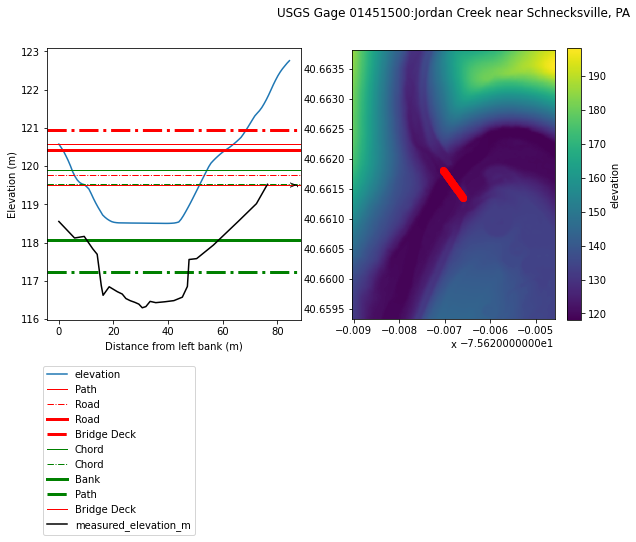

In [9]:
index = 0

m = plotGageLocation(index=index,
                       gage_location=gage_location,
                       gage_path=gage_path,
                       gage_thresholds=gage_thresholds,
                       cross_sections=cross_sections)

plotGageXS_meas(index=index,
             gage_path=gage_path,
             gage_thresholds=gage_thresholds,
             cross_sections=cross_sections,
             meas_xs=gdf_geo_ca,
             gage_datum=gage_datum_m,
             dem = dem,
             dem_res=dem_res,
             tindex=[0,1,2,3,4,5,6,7,8])
m

In [10]:
interpTValues(gage_path=gage_path,
              gage_thresholds=gage_thresholds,
              gage_datum_m=gage_datum_m,
              dem=dem)

Gage, Gage Name, Threshold Name, Threshold Value, DEM Interpolated Value, Difference
01451500,  Jordan Creek near Schnecksville  PA,  Path,  119.5150432,  121.0732563562263,  -1.5582131562263015
01451500,  Jordan Creek near Schnecksville  PA,  Road,  119.7762568,  122.57305953724241,  -2.796802737242416
01451500,  Jordan Creek near Schnecksville  PA,  Road,  120.43218639999999,  122.30284790268215,  -1.8706615026821538
01451500,  Jordan Creek near Schnecksville  PA,  Bridge Deck,  120.94333599999999,  120.86856208347392,  0.07477391652606968
01451500,  Jordan Creek near Schnecksville  PA,  Chord,  119.88598479999999,  118.48982966687028,  1.3961551331297102
01451500,  Jordan Creek near Schnecksville  PA,  Chord,  119.53272159999999,  120.85541975108309,  -1.3226981510831024
01451500,  Jordan Creek near Schnecksville  PA,  Bank,  118.06480479999999,  119.46003824205769,  -1.3952334420577017
01451500,  Jordan Creek near Schnecksville  PA,  Path,  117.2208136,  119.46337330767366,  -2.242

Available Resolution: res_3m:True, res_10m:True, res_30m:True


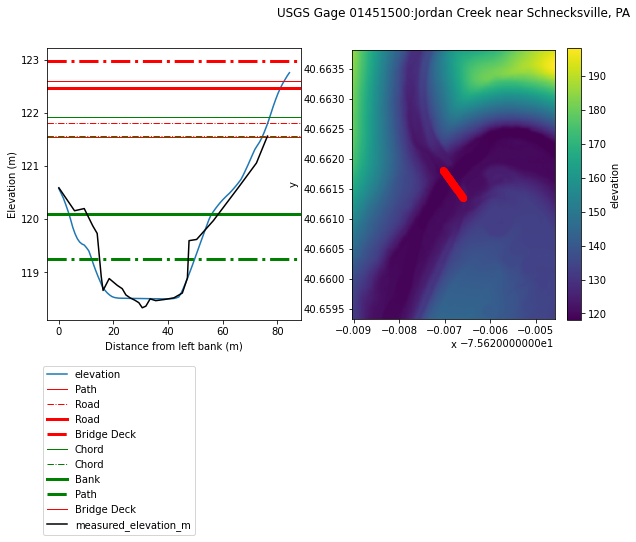

In [11]:
index = 0
offset = 2.04
gdf_geo_ca['measured_elevation_m'] = gage_datum_m[0] + (gdf_geo_ca['measured_elevation']*.3048) + offset
gage_datum_m_o = gage_datum_m.copy()
gage_datum_m_o[0] = gage_datum_m_o[0]+offset

m = plotGageLocation(index=index,
                       gage_location=gage_location,
                       gage_path=gage_path,
                       gage_thresholds=gage_thresholds,
                       cross_sections=cross_sections)

plotGageXS_meas(index=index,
             gage_path=gage_path,
             gage_thresholds=gage_thresholds,
             cross_sections=cross_sections,
             meas_xs=gdf_geo_ca,
             gage_datum=gage_datum_m_o,
             dem = dem,
             dem_res=dem_res,
             tindex=[0,1,2,3,4,5,6,7,8])

In [12]:
gage_datum_m

[115.969]

In [13]:
gage_datum_m_o

[118.009]